<a href="https://colab.research.google.com/github/vaibhavrediwal/analysis_hate_speech/blob/main/Assignment_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task 1: Data Analysis & Preprocessing

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4298 entries, 0 to 4297
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                4298 non-null   int64  
 1   id                        4298 non-null   int64  
 2   timestamp_edge            4298 non-null   object 
 3   timestamp_inserted        4298 non-null   object 
 4   device_id                 4298 non-null   int64  
 5   output_power_kW           4298 non-null   int64  
 6   output_current_A          4298 non-null   int64  
 7   energy_counter_MWh        4298 non-null   float64
 8   net_frequency_Hz          4298 non-null   float64
 9   net_AC_voltage_V          4298 non-null   int64  
 10  DC_voltage_DCV            4298 non-null   int64  
 11  average_cosphii_percent   4298 non-null   float64
 12  status                    4298 non-null   object 
 13  start_conditions          4298 non-null   obj

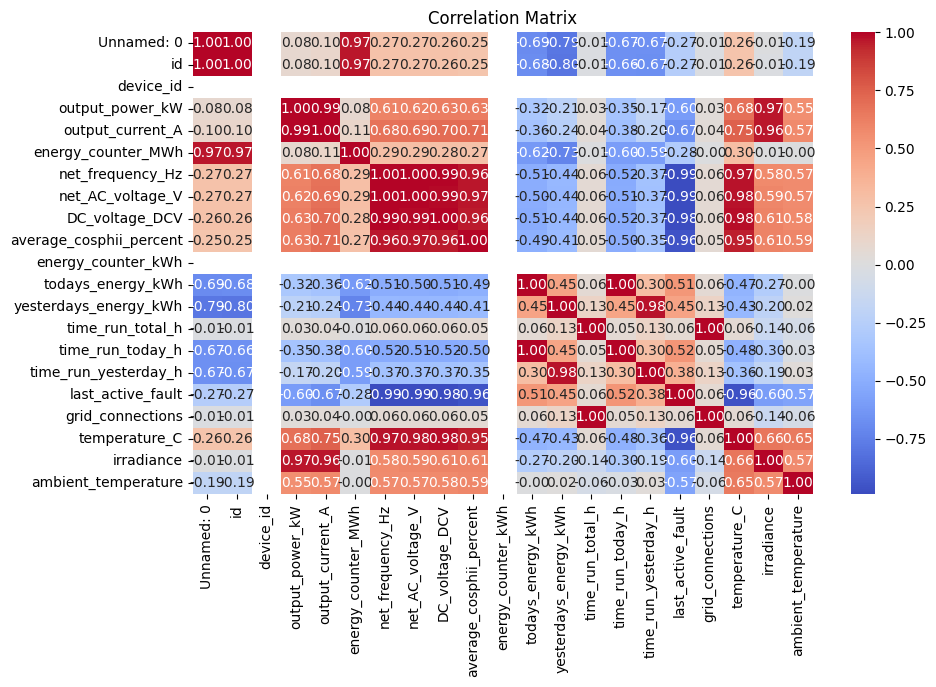


Preprocessing complete. Feature shape: (4298, 5)


<ipython-input-4-2c2a60190612>:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['irradiance'].fillna(data['irradiance'].mean(), inplace=True)
<ipython-input-4-2c2a60190612>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file_path = 'solar_energy_forecasting.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Data Analysis
print("Dataset Overview:")
print(data.info())
print("\nMissing Values:\n", data.isnull().sum())
print("\nStatistical Summary:\n", data.describe())

# Visualize patterns and check correlations
# Visualize patterns and check correlations
numeric_cols = data.select_dtypes(include=['number'])  # Select only numeric columns
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


# Handle missing values
data['irradiance'].fillna(data['irradiance'].mean(), inplace=True)
data['ambient_temperature'].fillna(data['ambient_temperature'].mean(), inplace=True)

# Remove redundant or constant columns
columns_to_drop = [
    'Unnamed: 0', 'id', 'timestamp_inserted', 'device_id',
    'specific_unit_monitoring', 'energy_counter_kWh'
]
data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Convert time columns to datetime
data['timestamp_edge'] = pd.to_datetime(data['timestamp_edge'])
data['hour'] = data['timestamp_edge'].dt.hour
data['day_of_week'] = data['timestamp_edge'].dt.dayofweek

# Outlier handling (e.g., capping extreme values)
for col in ['temperature_C', 'irradiance', 'ambient_temperature']:
    data[col] = np.clip(data[col], data[col].quantile(0.01), data[col].quantile(0.99))

# Feature Engineering
features = ['temperature_C', 'irradiance', 'ambient_temperature', 'hour', 'day_of_week']
target = 'output_power_kW'

# Preprocessing pipeline
X = data[features]
y = data[target]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nPreprocessing complete. Feature shape:", X_scaled.shape)


Task 2: Model Development

In [1]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential # Import Sequential here
from tensorflow.keras.layers import (
    Dense, LSTM, Dropout, Input, LayerNormalization, MultiHeadAttention, Flatten
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape data for LSTM (samples, timesteps, features)
X_train_lstm = np.expand_dims(X_train, axis=1)
X_test_lstm = np.expand_dims(X_test, axis=1)

# Model 1: LSTM
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

lstm_model = build_lstm_model(X_train_lstm.shape[1:])

# Model 2: Transformer
def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LayerNormalization()(inputs)
    x = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(1, activation='linear')(x)
    model = Model(inputs, x)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

transformer_model = build_transformer_model((1, X_train.shape[1]))

# Training Pipeline
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5)
]

# Train LSTM Model
lstm_model.fit(
    X_train_lstm, y_train,
    validation_data=(X_test_lstm, y_test),
    epochs=50, batch_size=32, callbacks=callbacks
)

# Train Transformer Model
transformer_model.fit(
    np.expand_dims(X_train, axis=1), y_train,
    validation_data=(np.expand_dims(X_test, axis=1), y_test),
    epochs=50, batch_size=32, callbacks=callbacks
)


NameError: name 'X_scaled' is not defined

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluate LSTM
y_pred_lstm = lstm_model.predict(X_test_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
print(f"LSTM - MSE: {mse_lstm}, MAE: {mae_lstm}")

# Evaluate Transformer
y_pred_transformer = transformer_model.predict(np.expand_dims(X_test, axis=1))
mse_transformer = mean_squared_error(y_test, y_pred_transformer)
mae_transformer = mean_absolute_error(y_test, y_pred_transformer)
print(f"Transformer - MSE: {mse_transformer}, MAE: {mae_transformer}")

# Concept Drift Handling (Placeholder - implement with new data streams)
# Retrain model with a combination of old + new data
def update_model_with_new_data(model, X_new, y_new):
    model.fit(X_new, y_new, epochs=10, batch_size=32)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
LSTM - MSE: 656.819333822539, MAE: 7.704205675596414
 1/27 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Transformer - MSE: 14727.311821038176, MAE: 55.01423522474807


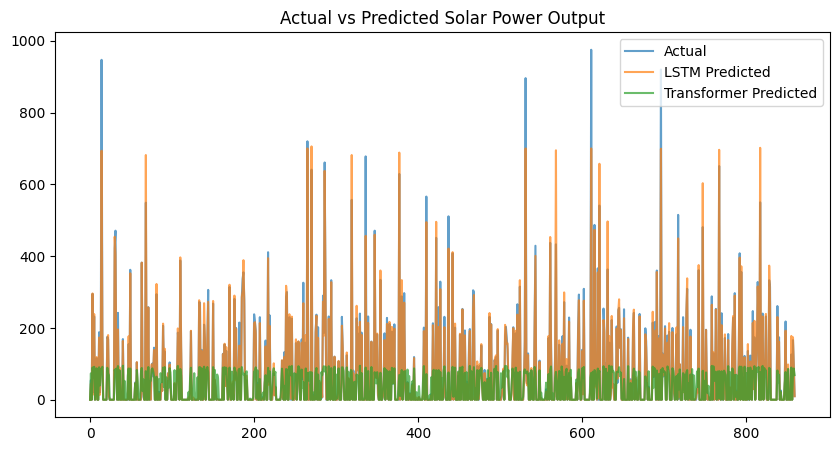

In [ ]:
# Visualization of Predictions
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual', alpha=0.7)
plt.plot(y_pred_lstm.flatten(), label='LSTM Predicted', alpha=0.7)
plt.plot(y_pred_transformer.flatten(), label='Transformer Predicted', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted Solar Power Output')
plt.show()


Training with params: LSTM Units=32, Dropout=0.2, LR=0.001, Batch Size=32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Validation MSE: 704.0980946905975
Training with params: LSTM Units=32, Dropout=0.2, LR=0.001, Batch Size=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Validation MSE: 24083.47549268464
Training with params: LSTM Units=32, Dropout=0.2, LR=0.0005, Batch Size=32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Validation MSE: 24088.03897076646
Training with params: LSTM Units=32, Dropout=0.2, LR=0.0005, Batch Size=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Validation MSE: 24207.02127724608
Training with params: LSTM Units=32, Dropout=0.3, LR=0.001, Batch Size=32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Validation MSE: 23716.19712986238
Training with params: LSTM Units=32, Dropout=0.3, LR=0.001, Batch Size=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Validation MSE: 24226.526141171948
Training with params: LSTM Units=32, Dropout=0.3, LR=0.0005, Batch Size=32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Validation MSE: 24163.818420663203
Training with params: LSTM Units=32, Dropout=0.3, LR=0.0005, Batch Size=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Validation MSE: 24215.213551670095
Training with params: LSTM Units=64, Dropout=0.2, LR=0.001, Batch Size=32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Validation MSE: 22122.71208262059
Training with params: LSTM Units=64, Dropout=0.2, LR=0.001, Batch Size=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Validation MSE: 23945.177709617976
Training with params: LSTM Units=64, Dropout=0.2, LR=0.0005, Batch Size=32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Validation MSE: 23812.017372588987
Training with params: LSTM Units=64, Dropout=0.2, LR=0.0005, Batch Size=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Validation MSE: 24201.10096878958
Training with params: LSTM Units=64, Dropout=0.3, LR=0.001, Batch Size=32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Validation MSE: 21859.809179351287
Training with params: LSTM Units=64, Dropout=0.3, LR=0.001, Batch Size=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Validation MSE: 23858.636675445327
Training with params: LSTM Units=64, Dropout=0.3, LR=0.0005, Batch Size=32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Validation MSE: 24031.02535961726
Training with params: LSTM Units=64, Dropout=0.3, LR=0.0005, Batch Size=64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


Validation MSE: 24183.43163601541
Best Model Parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}, Best Validation MSE: 704.0980946905975
Updating model with new data...
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Final Metrics:
MSE: 731.5224664387931, RMSE: 27.046672003017175, MAE: 8.38190073689749


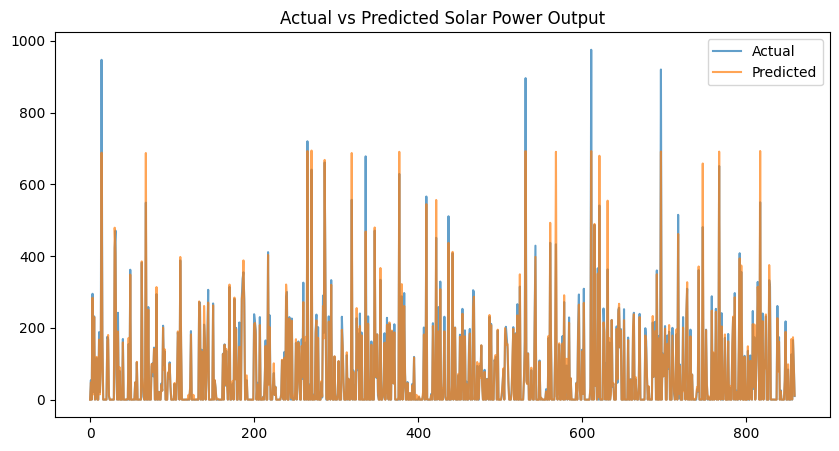

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Hyperparameter Configuration
hyperparams = {
    "lstm_units": [32, 64],
    "dropout_rate": [0.2, 0.3],
    "learning_rate": [0.001, 0.0005],
    "batch_size": [32, 64],
}

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_lstm = np.expand_dims(X_train, axis=1)
X_test_lstm = np.expand_dims(X_test, axis=1)

# Define Model
def build_lstm_model(input_shape, lstm_units, dropout_rate, learning_rate):
    model = Sequential([
        LSTM(lstm_units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(lstm_units // 2, return_sequences=False),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

# Early Stopping and Learning Rate Scheduling
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5)
]

# Hyperparameter Optimization
best_model = None
best_mse = float('inf')
best_params = {}

for lstm_units in hyperparams["lstm_units"]:
    for dropout_rate in hyperparams["dropout_rate"]:
        for learning_rate in hyperparams["learning_rate"]:
            for batch_size in hyperparams["batch_size"]:
                print(f"Training with params: LSTM Units={lstm_units}, Dropout={dropout_rate}, LR={learning_rate}, Batch Size={batch_size}")

                # Build and train the model
                model = build_lstm_model(X_train_lstm.shape[1:], lstm_units, dropout_rate, learning_rate)
                model.fit(
                    X_train_lstm, y_train,
                    validation_data=(X_test_lstm, y_test),
                    epochs=50, batch_size=batch_size, callbacks=callbacks, verbose=0
                )

                # Evaluate the model
                y_pred = model.predict(X_test_lstm)
                mse = mean_squared_error(y_test, y_pred)
                print(f"Validation MSE: {mse}")

                # Update best model if needed
                if mse < best_mse:
                    best_model = model
                    best_mse = mse
                    best_params = {
                        "lstm_units": lstm_units,
                        "dropout_rate": dropout_rate,
                        "learning_rate": learning_rate,
                        "batch_size": batch_size
                    }

print(f"Best Model Parameters: {best_params}, Best Validation MSE: {best_mse}")

# Save the best model
best_model.save('best_lstm_model.h5')

# Handle Concept Drift (Update with new data)
def update_model_with_new_data(model, X_new, y_new):
    print("Updating model with new data...")
    model.fit(X_new, y_new, epochs=10, batch_size=best_params['batch_size'], verbose=0)

# Simulate new data (replace with real incoming data)
X_new = X_test_lstm[:100]
y_new = y_test[:100]
update_model_with_new_data(best_model, X_new, y_new)

# Document Model Performance Metrics
y_pred_final = best_model.predict(X_test_lstm)
final_mse = mean_squared_error(y_test, y_pred_final)
final_rmse = np.sqrt(final_mse)
final_mae = mean_absolute_error(y_test, y_pred_final)

print(f"Final Metrics:\nMSE: {final_mse}, RMSE: {final_rmse}, MAE: {final_mae}")

# Visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual', alpha=0.7)
plt.plot(y_pred_final.flatten(), label='Predicted', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted Solar Power Output')
plt.show()
